# Data orgnization and train test split

In [1]:
import os
import pandas as pd

In [3]:

origin_image_dir = "datasets/raw_datas/00_UAV-derived Thermal Waterfowl Dataset/01_Posistive Image"

img_length = len(os.listdir(origin_image_dir))
print(f"Total images: {img_length}")

Total images: 355


In [4]:
labels_df = pd.read_csv("datasets/raw_datas/00_UAV-derived Thermal Waterfowl Dataset/02_Groundtruth Label for Positive Images/Bounding Box Label.csv")
print(f"Total labels: {len(labels_df)}")
print(labels_df.head())

Total labels: 8975
               imageFilename  x(column)  y(row)  width  height
0  20180322_101536_979_R.tif        127      11      7       7
1  20180322_101536_979_R.tif        174      32      7       7
2  20180322_101536_979_R.tif        178      19      7       7
3  20180322_101536_979_R.tif        199      31      7       7
4  20180322_101536_979_R.tif        223      51      7       7


In [11]:
img_names = labels_df['imageFilename'].unique()
print(f"Total images with labels: {len(img_names)}")
print(img_names[:5])
img_names = [os.path.join(origin_image_dir, name) for name in img_names]
print(img_names[:5])

Total images with labels: 355
['20180322_101536_979_R.tif' '20180322_101537_980_R.tif'
 '20180322_101538_982_R.tif' '20180322_101539_982_R.tif'
 '20180322_101540_982_R.tif']
['datasets/raw_datas/00_UAV-derived Thermal Waterfowl Dataset/01_Posistive Image/20180322_101536_979_R.tif', 'datasets/raw_datas/00_UAV-derived Thermal Waterfowl Dataset/01_Posistive Image/20180322_101537_980_R.tif', 'datasets/raw_datas/00_UAV-derived Thermal Waterfowl Dataset/01_Posistive Image/20180322_101538_982_R.tif', 'datasets/raw_datas/00_UAV-derived Thermal Waterfowl Dataset/01_Posistive Image/20180322_101539_982_R.tif', 'datasets/raw_datas/00_UAV-derived Thermal Waterfowl Dataset/01_Posistive Image/20180322_101540_982_R.tif']


In [12]:
# split the dataset into train and test sets with 90% train and 10% val
from sklearn.model_selection import train_test_split
train_names, val_names = train_test_split(img_names, test_size=0.15, random_state=42)
print(f"Train images: {len(train_names)}")
print(f"Validation images: {len(val_names)}")


Train images: 301
Validation images: 54


In [15]:
from PIL import Image
import shutil
from tqdm import tqdm
import cv2
import os

def tile_images_with_labels(image, xxyy_boxes, tile_size=128, overlap=0.2):
    height, width = image.shape[:2]
    stride = int(tile_size * (1 - overlap))

    tiled_images = []
    tiled_boxes = []

    def is_in_box(inner_box, border):
        x1,y1,x2,y2 = inner_box
        x,y,x_end,y_end = border
        return x<=x1<=x_end and x<=x2<=x_end and y<=y1<=y_end and y<=y2<=y_end

    for y in range(0, height, stride):
        for x in range(0, width, stride):
            x_end = min(x + tile_size, width)
            y_end = min(y + tile_size, height)

            # check if the tile is smaller than tile_size, if so, adjust the start position
            if x_end - x < tile_size:
                x = max(0, x_end - tile_size)
            if y_end - y < tile_size:
                y = max(0, y_end - tile_size)
            x_end = min(x + tile_size, width)
            y_end = min(y + tile_size, height)

            tile = image[y:y_end, x:x_end]
            tiled_images.append(tile)

            # check all the xxyy_boxes, if it in the image, translate it
            boxes_in_tile = []
            for box in xxyy_boxes:
                boarder_box = (x, y, x_end, y_end)
                if is_in_box(box, boarder_box):
                    x1, y1, x2, y2 = box
                    translated_box = [x1 - x, y1 - y, x2 - x, y2 - y]
                    boxes_in_tile.append(translated_box)
            tiled_boxes.append(boxes_in_tile)
    return tiled_images, tiled_boxes

def convert_to_yolo_format(row, img_width, img_height):
    x_center = (row['x(column)'] + row['width'] * 0.5) / img_width
    y_center = (row['y(row)'] + row['height'] * 0.5) / img_height
    width = row['width'] / img_width
    height = row['height'] / img_height
    return f"0 {x_center} {y_center} {width} {height}"  # Assuming class '0' for waterfowl

def rect_to_xxyy(row):
    x1 = row['x(column)']
    y1 = row['y(row)']
    x2 = x1 + row['width']
    y2 = y1 + row['height']
    return x1, y1, x2, y2

def xxyy_to_yolo_format(xxyy, img_width, img_height):
    x1, y1, x2, y2 = xxyy
    x_center = (x1 + x2) / 2 / img_width
    y_center = (y1 + y2) / 2 / img_height
    width = (x2 - x1) / img_width
    height = (y2 - y1) / img_height
    return f"0 {x_center} {y_center} {width} {height}"  # Assuming class '0' for waterfowl

def process_dataset(image_paths:list[str], subset:str, root_data_dir:str):
    for img_path in tqdm(image_paths):
        img_name = os.path.basename(img_path)
        label_rows = labels_df[labels_df['imageFilename'] == img_name]
        
        # Get image dimensions
        with Image.open(img_path) as img:
            img_width, img_height = img.size
        
        # Create label file content
        yolo_labels = []
        for _, row in label_rows.iterrows():
            yolo_label = convert_to_yolo_format(row, img_width, img_height)
            yolo_labels.append(yolo_label)
        
        # Write label file
        label_file_path = os.path.join(root_data_dir, subset, "labels", img_name.replace('.tif', '.txt'))
        with open(label_file_path, 'w') as f:
            f.write('\n'.join(yolo_labels))
        
        # Copy image to train images directory
        shutil.copy(img_path, os.path.join(root_data_dir, subset, "images", img_name))

def process_dataset_and_tile(image_paths:list[str], subset:str, root_data_dir:str, tile_size:int = 128, overlap:float = 0.2):
    images_dir = os.path.join(root_data_dir, subset, "images")
    labels_dir = os.path.join(root_data_dir, subset, "labels")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for img_path in tqdm(image_paths):
        img_name = os.path.basename(img_path)
        label_rows = labels_df[labels_df['imageFilename'] == img_name]
        
        # Get image dimensions
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        
        # Create label file content
        xxyy_boxes = []
        for _, row in label_rows.iterrows():
            box = rect_to_xxyy(row)
            xxyy_boxes.append(box)
        
        # Tiling logic
        tiled_imges, tiled_boxes = tile_images_with_labels(image, xxyy_boxes, tile_size, overlap)
        for idx, (tiled_img, boxes) in enumerate(zip(tiled_imges, tiled_boxes)):
            tile_img_name = img_name.replace('.tif', f'_tile_{idx}.tif')
            tile_label_name = tile_img_name.replace('.tif', '.txt')
            
            # Save tiled image
            cv2.imwrite(os.path.join(images_dir, tile_img_name), tiled_img)
            
            # Convert boxes to YOLO format
            yolo_labels = []
            for box in boxes:
                yolo_label = xxyy_to_yolo_format(box, tiled_img.shape[1], tiled_img.shape[0])
                yolo_labels.append(yolo_label)
            
            # Save label file
            with open(os.path.join(labels_dir, tile_label_name), 'w') as f:
                f.write('\n'.join(yolo_labels))
    
def create_data_directories(root_data_dir:str):
    subsets = ['train', 'val']
    for subset in subsets:
        images_dir = os.path.join(root_data_dir, subset, "images")
        labels_dir = os.path.join(root_data_dir, subset, "labels")
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)

In [25]:
root_data_dir = "datasets/yolo_tiled_waterfowl_balanced"
os.makedirs(os.path.join(root_data_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(root_data_dir, "val"), exist_ok=True)
os.makedirs(os.path.join(root_data_dir, "train", "images"), exist_ok=True)
os.makedirs(os.path.join(root_data_dir, "train", "labels"), exist_ok=True)
os.makedirs(os.path.join(root_data_dir, "val", "images"), exist_ok=True)
os.makedirs(os.path.join(root_data_dir, "val", "labels"), exist_ok=True)


# process_dataset_and_tile(train_names, "train", root_data_dir)
# process_dataset_and_tile(val_names, "val", root_data_dir)


# Visualize label

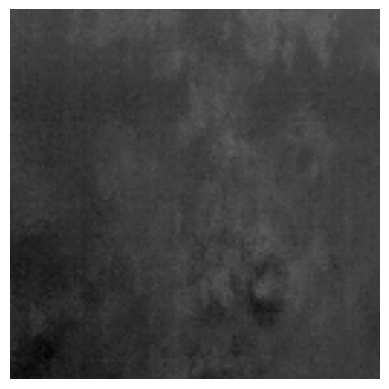

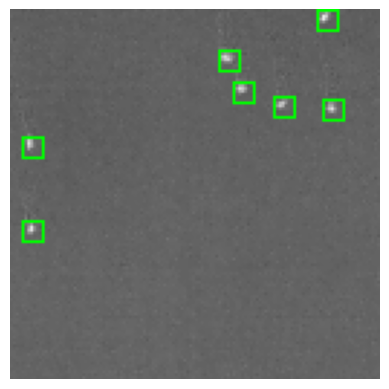

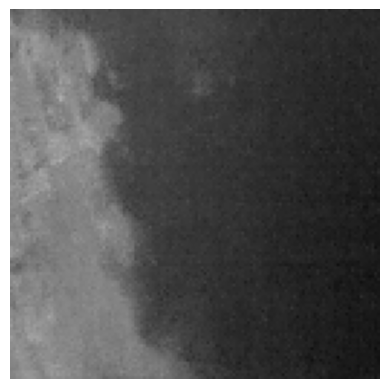

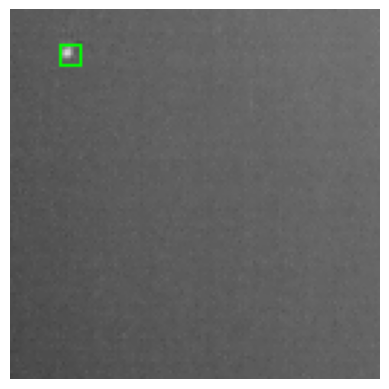

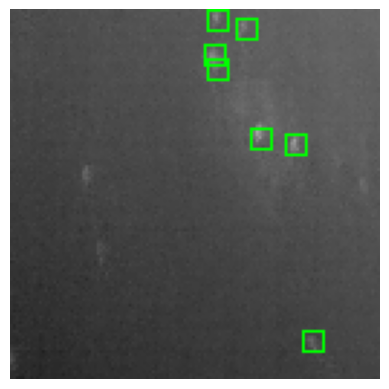

In [29]:
import matplotlib.pyplot as plt
import cv2

root_data_dir = "datasets/yolo_tiled_waterfowl_balanced"
def visualize_sample(image_path, label_path):
    img = cv2.imread(image_path)
    height, width, _ = img.shape    
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1]) * width
            y_center = float(parts[2]) * height
            box_width = float(parts[3]) * width
            box_height = float(parts[4]) * height
            
            x1 = int(x_center - box_width / 2)
            y1 = int(y_center - box_height / 2)
            x2 = int(x_center + box_width / 2)
            y2 = int(y_center + box_height / 2)
            
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# get imagenames
im_names = os.listdir(os.path.join(root_data_dir, "train", "images"))

for img_name in im_names[:5]:
    image_path = os.path.join(root_data_dir, "train", "images", img_name)
    label_path = os.path.join(root_data_dir, "train", "labels", img_name.replace('.tif', '.txt'))
    visualize_sample(image_path, label_path)




# Compute negative and postive Ratio

In [27]:
import os

d_dir= "datasets/yolo_tiled_waterfowl_balanced/train"
imgs_dir = os.path.join(d_dir, "images")
labels_dir = os.path.join(d_dir, "labels")
im_names = os.listdir(imgs_dir)
lb_paths = [os.path.join(labels_dir, im_name.replace('.tif', '.txt')) for im_name in im_names]
# cout the number with no labels
no_label_count = 0
for lb_path in lb_paths:
    if os.path.getsize(lb_path) == 0:
        no_label_count += 1
print(f"Number of images with no labels in training set: {no_label_count}")
print(f"Total training images: {len(lb_paths)}")
# compute ratio
ratio_no_label = no_label_count / len(lb_paths)
print(f"Ratio of images with no labels in training set: {ratio_no_label:.2%}")
# portion with labels
ratio_with_label = 1 - ratio_no_label
portion = ratio_no_label/ratio_with_label
print(f"Ratio of images with labels in training set: {ratio_with_label:.2%}")
print(f"Portion of no-label to with-label images in training set: {portion:.2f}")


Number of images with no labels in training set: 4390
Total training images: 8049
Ratio of images with no labels in training set: 54.54%
Ratio of images with labels in training set: 45.46%
Portion of no-label to with-label images in training set: 1.20


In [26]:
src_datset = "datasets/yolo_tiled_waterfowl"
target_dataset = "datasets/yolo_tiled_waterfowl_balanced"

import shutil
import random

# copy all with-label images
src_imgs_dir = os.path.join(src_datset, "train", "images")
src_labels_dir = os.path.join(src_datset, "train", "labels")
tgt_imgs_dir = os.path.join(target_dataset, "train", "images")
tgt_labels_dir = os.path.join(target_dataset, "train", "labels")
os.makedirs(tgt_imgs_dir, exist_ok=True)
os.makedirs(tgt_labels_dir, exist_ok=True)

im_names = os.listdir(src_imgs_dir)
no_label_names = []
for im_name in im_names:
    lb_path = os.path.join(src_labels_dir, im_name.replace('.tif', '.txt'))
    if os.path.getsize(lb_path) > 0:
        shutil.copy(os.path.join(src_imgs_dir, im_name), os.path.join(tgt_imgs_dir, im_name))
        shutil.copy(lb_path, os.path.join(tgt_labels_dir, im_name.replace('.tif', '.txt')))
    else:
        no_label_names.append(im_name)

# randomly select no-label images to copy
num_with_label = len(im_names) - len(no_label_names)
num_no_label_to_copy = int(num_with_label * 1.2)
no_label_sample = random.sample(no_label_names, num_no_label_to_copy)
for im_name in no_label_sample:
    lb_path = os.path.join(src_labels_dir, im_name.replace('.tif', '.txt'))
    shutil.copy(os.path.join(src_imgs_dir, im_name), os.path.join(tgt_imgs_dir, im_name))
    shutil.copy(lb_path, os.path.join(tgt_labels_dir, im_name.replace('.tif', '.txt')))
print("Balanced dataset created.")


Balanced dataset created.


# Add Negative data in

In [5]:
negative_image_dir = "datasets/46k66mz9sz-2/00_UAV-derived Thermal Waterfowl Dataset/00_UAV-derived Waterfowl Thermal Imagery Dataset/01_Thermal Images and Ground Truth (used for detector training and testing)/03_Negative Images"

negative_img_length = len(os.listdir(negative_image_dir))
print(f"Total negative images: {negative_img_length}")

Total negative images: 187


In [21]:
mixed_image_paths = [os.path.join(origin_image_dir, d) for d in os.listdir(origin_image_dir)] +\
                    [os.path.join(negative_image_dir, d) for d in os.listdir(negative_image_dir)]
print(mixed_image_paths[:5])
print(f"Total mixed images: {len(mixed_image_paths)}")

# split the mixed dataset into train and test sets with 90% train and 10% val
from sklearn.model_selection import train_test_split
mixed_train_paths, mixed_val_paths = train_test_split(mixed_image_paths, test_size=0.2, random_state=42)
print(f"Train images: {len(mixed_train_paths)}")
print(f"Validation images: {len(mixed_val_paths)}")

['datasets/46k66mz9sz-2/00_UAV-derived Thermal Waterfowl Dataset/00_UAV-derived Waterfowl Thermal Imagery Dataset/01_Thermal Images and Ground Truth (used for detector training and testing)/01_Posistive Image/20180322_101924_173_R.tif', 'datasets/46k66mz9sz-2/00_UAV-derived Thermal Waterfowl Dataset/00_UAV-derived Waterfowl Thermal Imagery Dataset/01_Thermal Images and Ground Truth (used for detector training and testing)/01_Posistive Image/20180322_101751_280_R.tif', 'datasets/46k66mz9sz-2/00_UAV-derived Thermal Waterfowl Dataset/00_UAV-derived Waterfowl Thermal Imagery Dataset/01_Thermal Images and Ground Truth (used for detector training and testing)/01_Posistive Image/20180322_102251_280_R.tif', 'datasets/46k66mz9sz-2/00_UAV-derived Thermal Waterfowl Dataset/00_UAV-derived Waterfowl Thermal Imagery Dataset/01_Thermal Images and Ground Truth (used for detector training and testing)/01_Posistive Image/20180322_102205_769_R.tif', 'datasets/46k66mz9sz-2/00_UAV-derived Thermal Waterfowl

In [26]:
# creat new dataset for mixed data
root_data_dir = "datasets/yolo_coco_with_neg"
create_data_directories(root_data_dir)
process_dataset(mixed_train_paths, "train", root_data_dir)
process_dataset(mixed_val_paths, "val", root_data_dir)

100%|██████████| 109/109 [00:00<00:00, 1028.45it/s]


# Change the box size of Test Ground Truth to match training data


In [35]:
import pandas as pd

birds_df = pd.read_csv("datasets/test/birds1.csv")
birds_df.head(10)

,x,y,w,h
0,538,311,5,5
1,3273,257,5,5
2,3271,253,5,5
3,3131,365,5,5
4,3179,420,5,5
5,3180,407,5,5
6,3171,409,5,5
7,3159,399,5,5
8,217,595,5,5
9,980,592,5,5


In [36]:
for index, row in birds_df.iterrows():
    x1 = row['x']
    y1 = row['y']
    width = row['w']
    height = row['h']
    x1-=1
    y1-=1
    width+=2
    height+=2
    birds_df.at[index, 'x'] = int(x1)
    birds_df.at[index, 'y'] = int(y1)
    birds_df.at[index, 'w'] = int(width)
    birds_df.at[index, 'h'] = int(height)
birds_df.to_csv("datasets/test/birds2.csv", index=False)

